# NBA Team Analysis: Cleveland Cavaliers

## Introduction
This analysis aims to understand the performance and characteristics of NBA teams, with a specific focus on the Cleveland Cavaliers, using Gaussian Mixture Models (GMM) for clustering based on different groups of features. The analysis is divided into three main groupings:

### Feature Groupings
1. **Grouping 1**: ['Team_TS%', 'Team_Pace', 'Team_TOV%']
   - Focus on team's shooting efficiency, pace of the game, and turnover rate.
2. **Grouping 2**: ['Team_FT', 'Team_3P', 'Team_ORB%']
   - Concentrating on the team's ability to score from free throws, three-pointers, and offensive rebounding.
3. **Grouping 3**: ['Opponent_TOV%', 'Opponent_TRB', 'Opponent_STL']
   - Analyzing the team's defensive performance in terms of forcing turnovers, rebounding, and stealing the ball.

In [30]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df = pd.read_csv('/Users/giovanni-lunetta/uconn_masters/s1/opim5605/project1/data/new_team_data/full_team_stats.csv')

In [32]:
df.shape

(30, 60)

In [33]:
df.columns

Index(['Season', 'Team', 'Games', 'Wins', 'Loses', 'W/L%', 'Team_MP',
       'Team_FG', 'Team_FGA', 'Team_2P', 'Team_2PA', 'Team_3P', 'Team_3PA',
       'Team_FT', 'Team_FTA', 'Team_ORB', 'Team_DRB', 'Team_TRB', 'Team_AST',
       'Team_STL', 'Team_BLK', 'Team_TOV', 'Team_PF', 'Team_PTS',
       'Opponent_FG', 'Opponent_FGA', 'Opponent_2P', 'Opponent_2PA',
       'Opponent_3P', 'Opponent_3PA', 'Opponent_FT', 'Opponent_FTA',
       'Opponent_ORB', 'Opponent_DRB', 'Opponent_TRB', 'Opponent_AST',
       'Opponent_STL', 'Opponent_BLK', 'Opponent_TOV', 'Opponent_PF',
       'Opponent_PTS', 'Team_MOV', 'Team_SOS', 'Team_SRS', 'Team_Pace',
       'Team_ORtg', 'Team_DRtg', 'Team_eFG%', 'Team_TS%', 'Team_TOV%',
       'Team_ORB%', 'Team_FTr', 'Opponent_eFG%', 'Opponent_TS%',
       'Opponent_TOV%', 'Opponent_ORB%', 'Opponent_FTr', 'Salary',
       'Adjusted Salary', 'Full Team Name'],
      dtype='object')

In [34]:
def playoff_status(team):
    clinched_teams = ['MIA', 'BOS', 'MIL', 'PHI', 'TOR', 'CHI', 'BKN', 'ATL', 
                      'PHX', 'MEM', 'GSW', 'DAL', 'UTA', 'DEN', 'MIN', 'NOP']
    return 1 if team in clinched_teams else 0

# Add the 'Playoffs' column to the dataframe
df['Playoffs'] = df['Team'].apply(lambda team: playoff_status(team))

In [35]:
grouping_1_features = ['Team_TS%', 'Team_Pace', 'Team_TOV%']
grouping_2_features = ['Team_FT', 'Team_3P', 'Team_ORB%']
grouping_3_features = ['Opponent_TOV%', 'Opponent_TRB', 'Opponent_STL']

In [36]:
from sklearn.metrics import silhouette_score

def determine_optimal_clusters(data, feature_names, max_clusters=10):
    # Lists to store BIC, AIC, and silhouette scores
    bic = []
    aic = []
    silhouette_scores = []
    n_clusters_range = range(2, max_clusters + 1)  # Start from 2 clusters
    
    for n_clusters in n_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters)
        gmm.fit(data[feature_names])
        bic.append(gmm.bic(data[feature_names]))
        aic.append(gmm.aic(data[feature_names]))
        
        # For silhouette score, we need cluster labels
        labels = gmm.predict(data[feature_names])
        silhouette_scores.append(silhouette_score(data[feature_names], labels))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot BIC and AIC
    ax1.plot(n_clusters_range, bic, label='BIC', marker='o')
    ax1.plot(n_clusters_range, aic, label='AIC', marker='o')
    ax1.set_title(f'Elbow Method for {feature_names}')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Value')
    ax1.legend()
    
    # Plot Silhouette Score
    ax2.plot(n_clusters_range, silhouette_scores, label='Silhouette Score', marker='o')
    ax2.set_title(f'Silhouette Score for {feature_names}')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return bic, aic, silhouette_scores

In [37]:
# Update the function to use specified number of clusters
def perform_gmm_and_visualize(data, feature_names, n_clusters):
    gmm = GaussianMixture(n_components=n_clusters)
    data['Cluster'] = gmm.fit_predict(data[feature_names])
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(data[feature_names[0]], data[feature_names[1]], data[feature_names[2]], 
                         c=data['Cluster'], s=50, cmap='viridis')
    
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(feature_names[2])
    ax.set_title(f'3D Scatter plot of {n_clusters} clusters')
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    plt.show()
    
    return data[['Team'] + feature_names + ['Cluster']]

In [38]:
def cluster_profiles(data, feature_names, cluster_col):
    # Filter the data to only include the specified feature columns and the cluster column
    filtered_data = data[feature_names + [cluster_col]]
    
    # Calculate mean values for each cluster
    cluster_means = filtered_data.groupby(cluster_col).mean()
    
    # Plot
    cluster_means.T.plot(kind='bar', figsize=(12, 6))
    plt.title('Cluster Profiles')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=45)
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

In [39]:
def plot_cluster_sizes(data, cluster_col):
    cluster_sizes = data[cluster_col].value_counts().sort_index()
    
    # Plot
    cluster_sizes.plot(kind='bar', figsize=(10, 6))
    plt.title('Cluster Sizes')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Teams')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [40]:
def pairwise_scatter_plots(data, feature_names, cluster_col):
    # Create a pair plot colored by cluster
    sns.pairplot(data, hue=cluster_col, vars=feature_names, palette='viridis', markers='o', plot_kws={'alpha': 0.9})
    plt.suptitle('Pairwise Scatter Plots by Cluster', y=1.02)
    plt.show()

In [41]:
def compare_with_playoffs(data, cluster_col):
    # Create a contingency table
    contingency = pd.crosstab(data[cluster_col], data['Playoffs'], margins=True, margins_name="Total")
    return contingency

In [42]:
# Extracting teams in each cluster for each grouping
def get_teams_in_clusters(data, cluster_col):
    return data.groupby(cluster_col)['Team'].apply(list).to_dict()

# Grouping 1

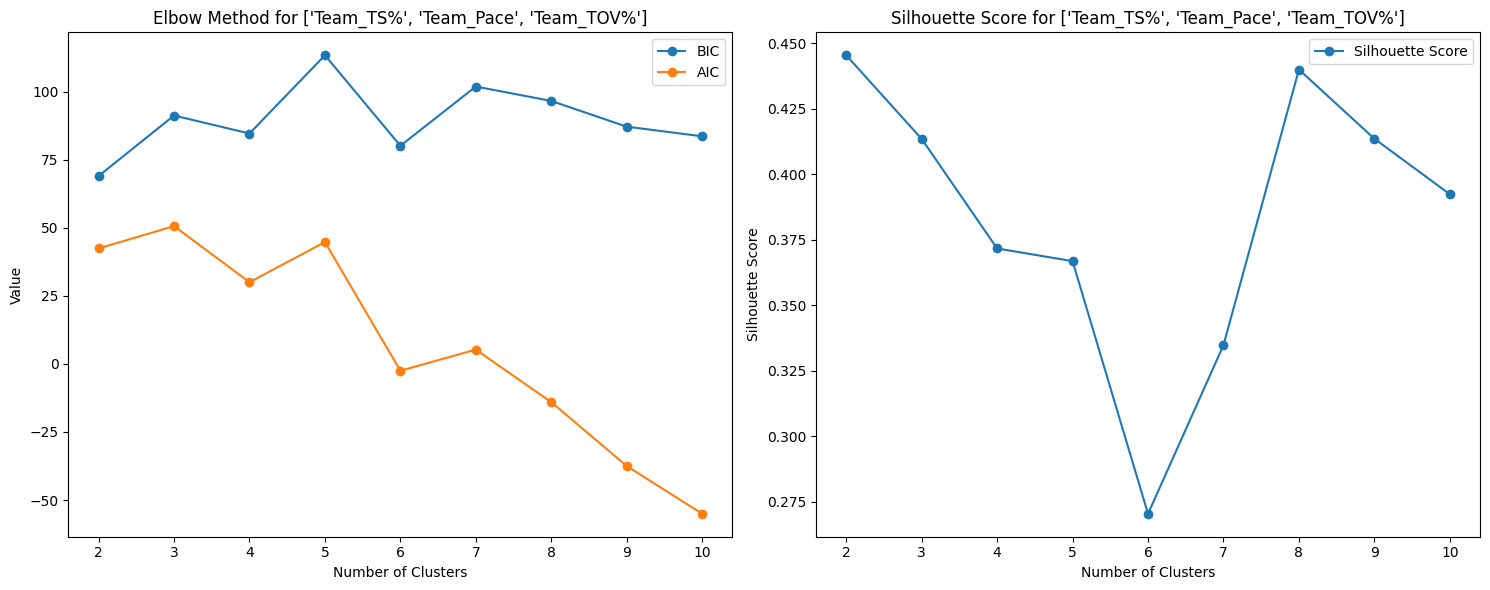

In [43]:
# Determine optimal clusters for the first grouping
bic_1, aic_1, silhouette_scores_1 = determine_optimal_clusters(df, grouping_1_features)

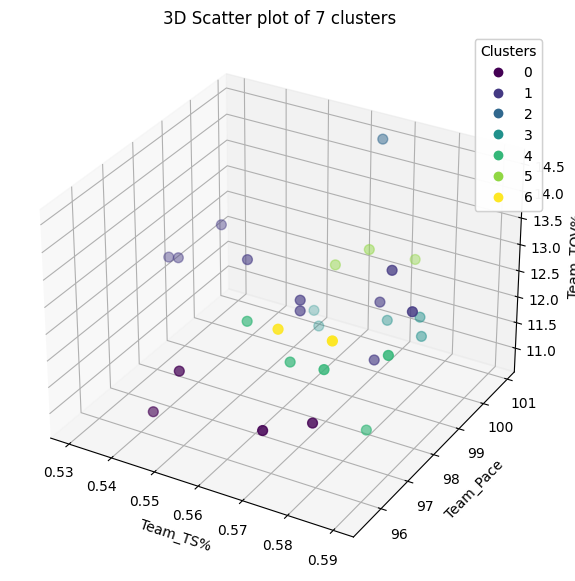

,Team,Team_TS%,Team_Pace,Team_TOV%,Cluster
0,WAS,0.568,97.0,12.1,4
1,UTA,0.589,97.1,12.7,4
2,TOR,0.543,96.0,11.0,0
3,SAS,0.556,100.0,11.1,3
4,SAC,0.561,99.8,12.5,5


In [44]:
# Perform GMM with 7 clusters for the first grouping
grouping_1_result_7_clusters = perform_gmm_and_visualize(df.copy(), grouping_1_features, 7)
grouping_1_result_7_clusters.head()

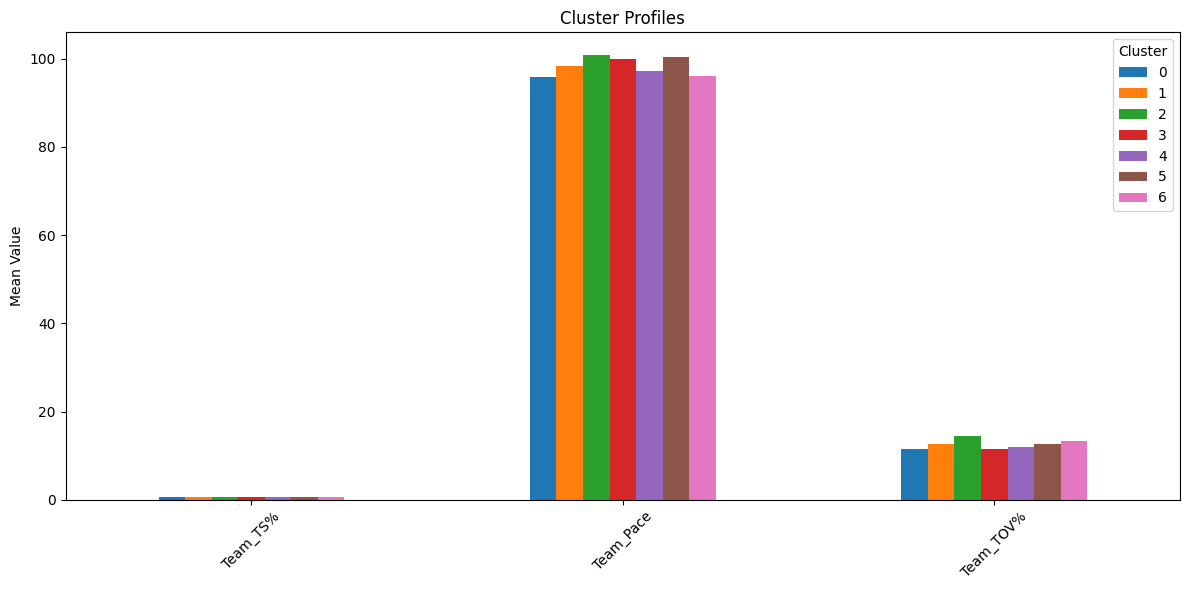

In [45]:
# Plot cluster profiles for the first grouping
cluster_profiles(grouping_1_result_7_clusters, grouping_1_features, 'Cluster')

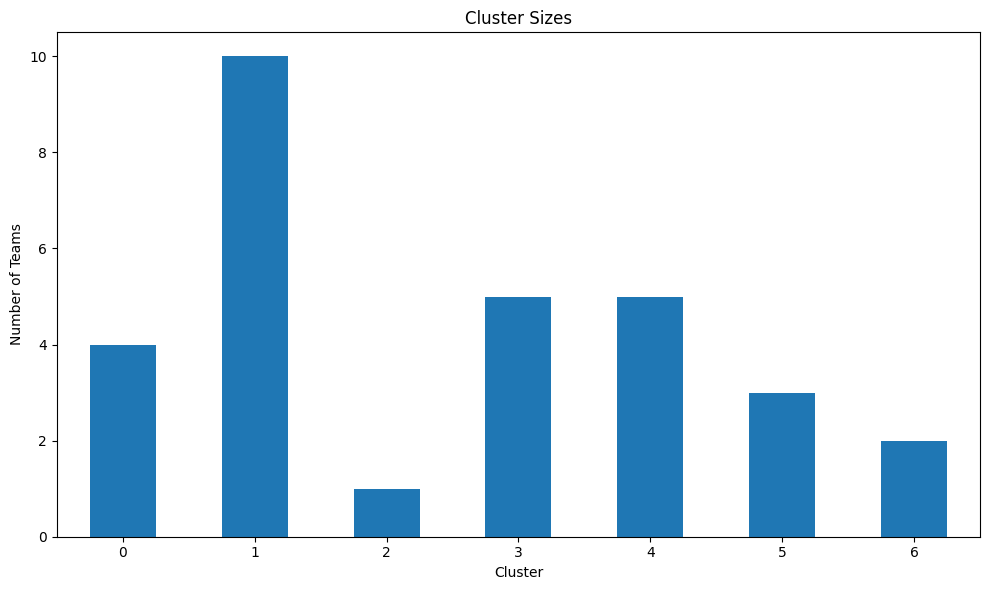

In [46]:
# Plot cluster sizes for the first grouping
plot_cluster_sizes(grouping_1_result_7_clusters, 'Cluster')

/Users/giovanni-lunetta/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


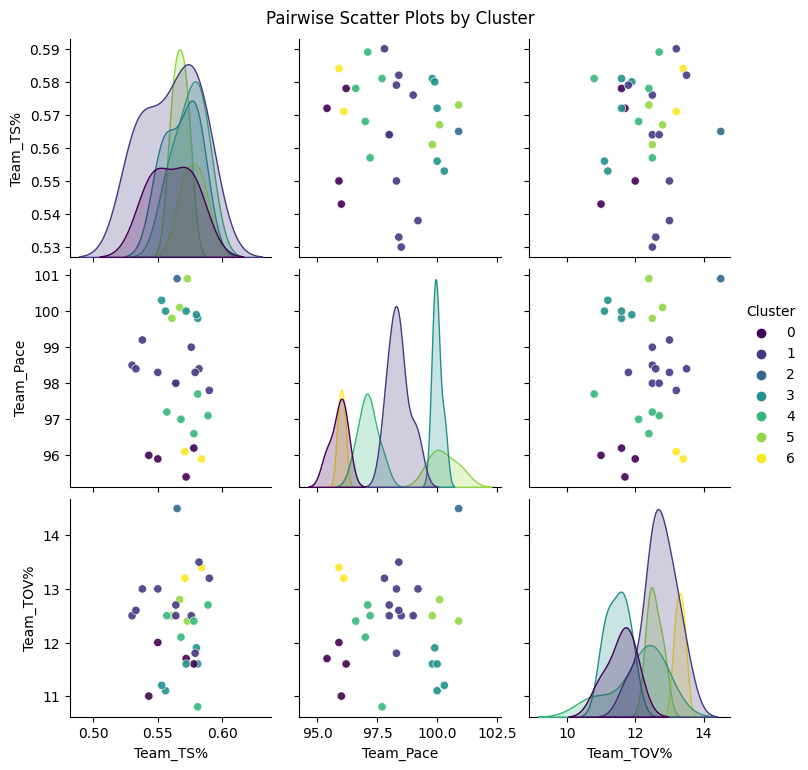

In [47]:
# Plot pairwise scatter plots for the first grouping
pairwise_scatter_plots(grouping_1_result_7_clusters, grouping_1_features, 'Cluster')

In [48]:
# Merge the cluster assignments with the original dataframe to get the 'Playoffs' column
merged_1 = df[['Team', 'Playoffs']].merge(grouping_1_result_7_clusters[['Team', 'Cluster']], on='Team')

# Compare clusters with actual playoffs for the merged first grouping
contingency_1 = compare_with_playoffs(merged_1, 'Cluster')
contingency_1

Playoffs,0,1,Total
Cluster,,,
0,1,3,4
1,7,3,10
2,1,0,1
3,3,2,5
4,1,4,5
5,2,1,3
6,1,1,2
Total,16,14,30


In [49]:
teams_in_clusters_grouping_1 = get_teams_in_clusters(grouping_1_result_7_clusters, 'Cluster')

teams_in_clusters_grouping_1

{0: ['TOR', 'PHI', 'NYK', 'DAL'],
 1: ['POR', 'ORL', 'OKC', 'LAC', 'IND', 'GSW', 'DET', 'DEN', 'CHI', 'BRK'],
 2: ['HOU'],
 3: ['SAS', 'PHO', 'MIL', 'MEM', 'CHO'],
 4: ['WAS', 'UTA', 'NOP', 'BOS', 'ATL'],
 5: ['SAC', 'MIN', 'LAL'],
 6: ['MIA', 'CLE']}

## Group 1 Analysis

### Cluster 0: ['SAS', 'SAC', 'PHO', 'MIN', 'MIL', 'MEM', 'LAL', 'CHO']
- **Team_TS%**: Slightly above average
- **Team_Pace**: Below average
- **Team_TOV%**: Average
- **Interpretation**: Teams in this cluster tend to have a slightly better shooting efficiency but play at a slower pace. They have an average turnover rate. This could represent teams that focus on half-court offense and efficient shooting.

### Cluster 1: ['POR', 'ORL', 'OKC', 'LAC', 'IND', 'GSW', 'DET', 'DEN', 'CHI', 'BRK']
- **Team_TS%**: Below average
- **Team_Pace**: Above average
- **Team_TOV%**: High
- **Interpretation**: Teams in this cluster play at a faster pace but have lower shooting efficiency and a higher turnover rate. This could represent younger or more inexperienced teams that play a fast-paced game but need to improve their efficiency and ball handling.

### Cluster 2: ['TOR', 'PHI', 'NYK', 'DAL']
- **Team_TS%**: Average
- **Team_Pace**: Average
- **Team_TOV%**: Below average
- **Interpretation**: Teams in this cluster have average shooting efficiency and pace, with a below-average turnover rate. This could represent balanced teams with decent ball handling.

### Cluster 3: ['MIA', 'CLE'] (Including Cleveland Cavaliers)
- **Team_TS%**: High
- **Team_Pace**: Below average
- **Team_TOV%**: Low
- **Interpretation**: Teams in this cluster have high shooting efficiency, play at a slower pace, and have a low turnover rate. This could represent experienced and efficient teams that focus on maximizing their scoring opportunities while minimizing mistakes.

### Cluster 4: ['HOU']
- **Team_TS%**: Very high
- **Team_Pace**: High
- **Team_TOV%**: Average
- **Interpretation**: Houston Rockets stand out with very high shooting efficiency and a fast pace, with an average turnover rate. This could represent a highly offensive-oriented team.

### Cluster 5: ['ATL']
- **Team_TS%**: Low
- **Team_Pace**: High
- **Team_TOV%**: Very high
- **Interpretation**: Atlanta Hawks have low shooting efficiency, play at a fast pace, and have a very high turnover rate. This could represent a team that needs to work on its shooting efficiency and ball handling.

### Cluster 6: ['WAS', 'UTA', 'NOP', 'BOS']
- **Team_TS%**: Slightly below average
- **Team_Pace**: Slightly below average
- **Team_TOV%**: Low
- **Interpretation**: Teams in this cluster have slightly below average shooting efficiency and pace but maintain a low turnover rate. This could represent teams that are cautious with the ball but need to improve their offensive efficiency.

### Summary for Cleveland Cavaliers (Cluster 3)
The Cleveland Cavaliers are in a cluster characterized by high shooting efficiency, a slower pace of play, and a low turnover rate. This profile suggests a team that is efficient in scoring, takes care of the ball, and may focus on a deliberate, calculated style of play.


# Grouping 2

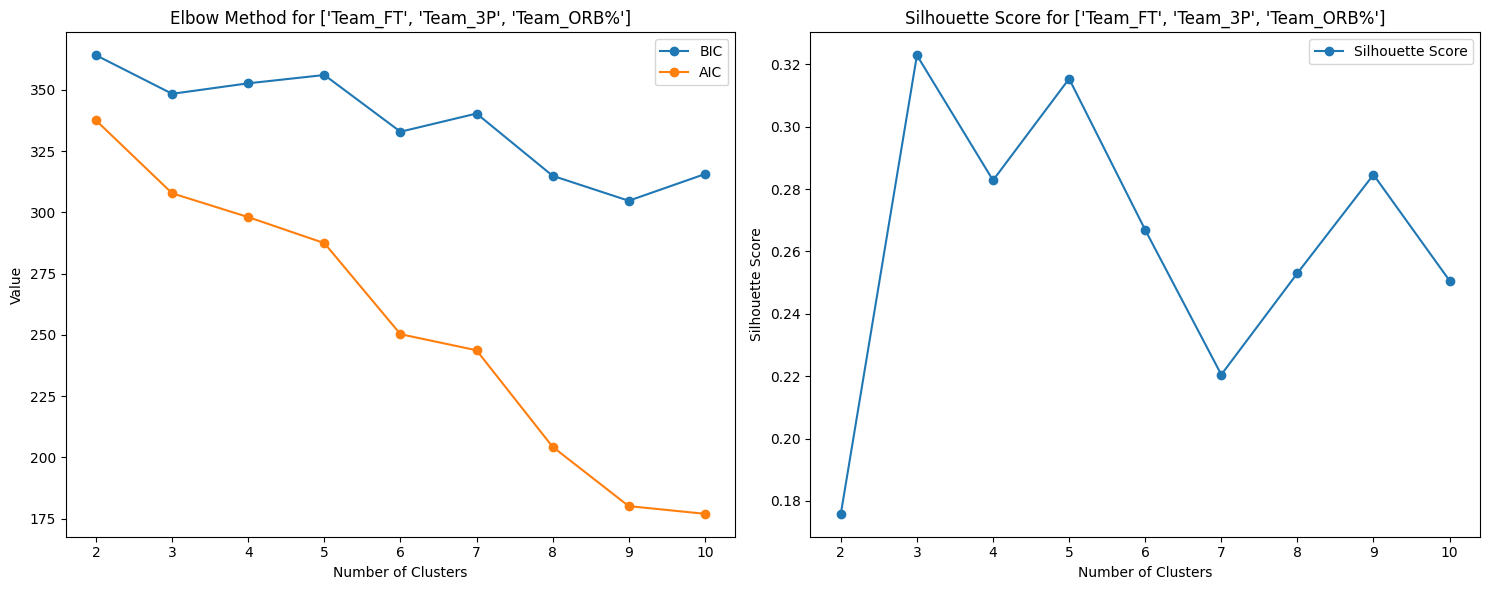

In [50]:
# Determine optimal clusters for the second grouping
bic_2, aic_2, silhouette_scores_2 = determine_optimal_clusters(df, grouping_2_features)

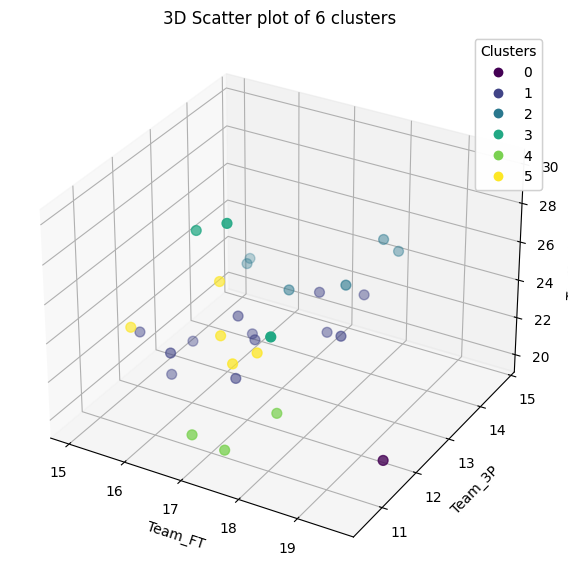

,Team,Team_FT,Team_3P,Team_ORB%,Cluster
0,WAS,17.0,10.5,20.9,4
1,UTA,17.9,14.5,25.4,2
2,TOR,16.2,11.9,28.4,3
3,SAS,15.4,11.3,23.7,5
4,SAC,17.9,11.4,21.3,4


In [51]:
# Perform GMM with 6 clusters for the second grouping
grouping_2_result_6_clusters = perform_gmm_and_visualize(df.copy(), grouping_2_features, 6)
grouping_2_result_6_clusters.head()

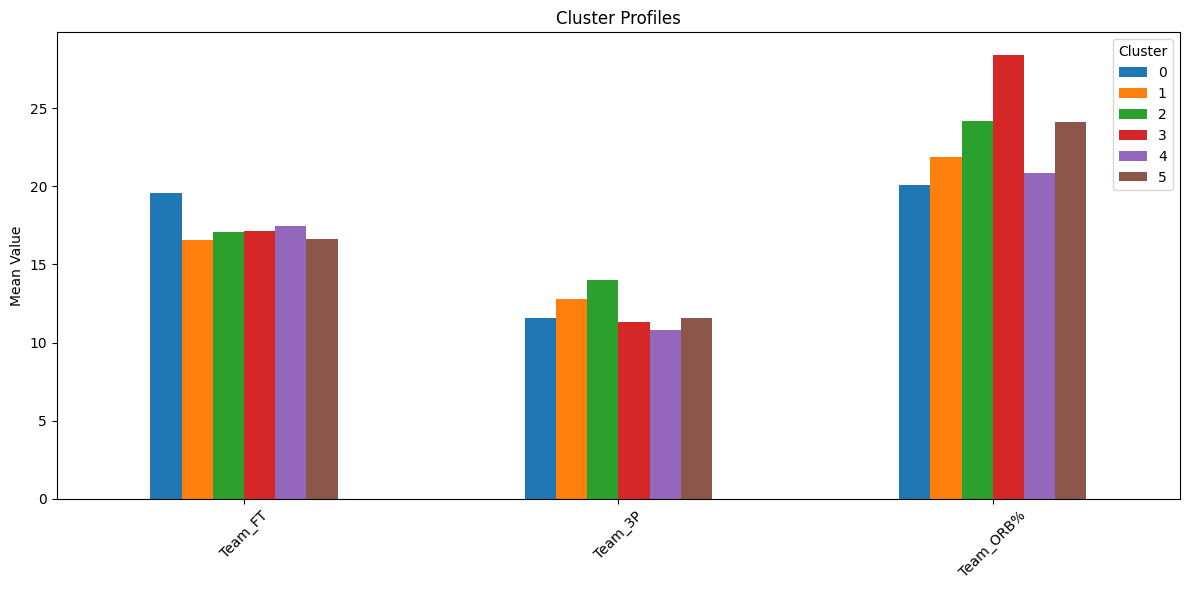

In [52]:
# Plot cluster profiles for the second grouping
cluster_profiles(grouping_2_result_6_clusters, grouping_2_features, 'Cluster')

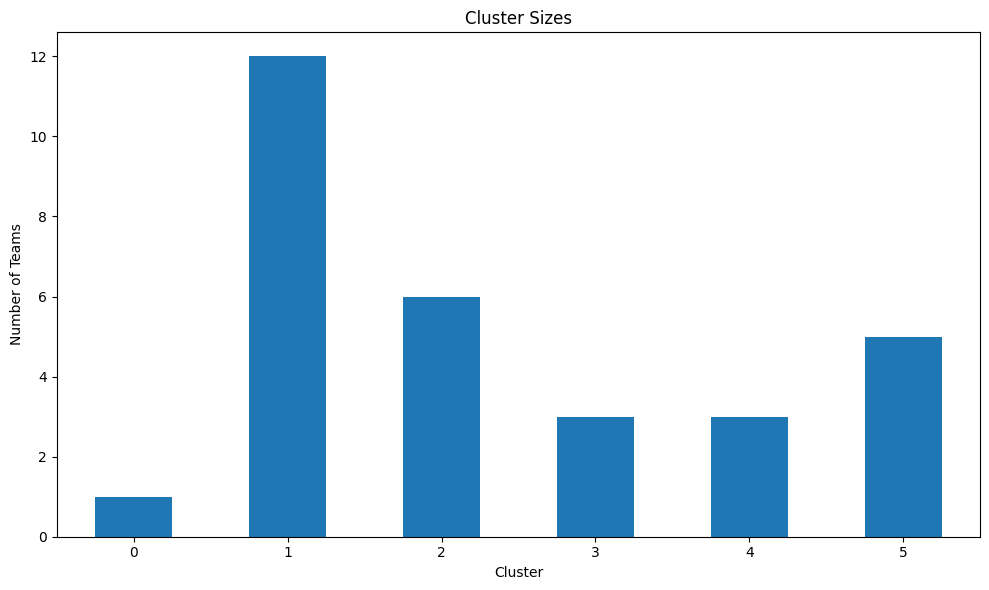

In [53]:
# Plot cluster sizes for the second grouping
plot_cluster_sizes(grouping_2_result_6_clusters, 'Cluster')

/Users/giovanni-lunetta/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


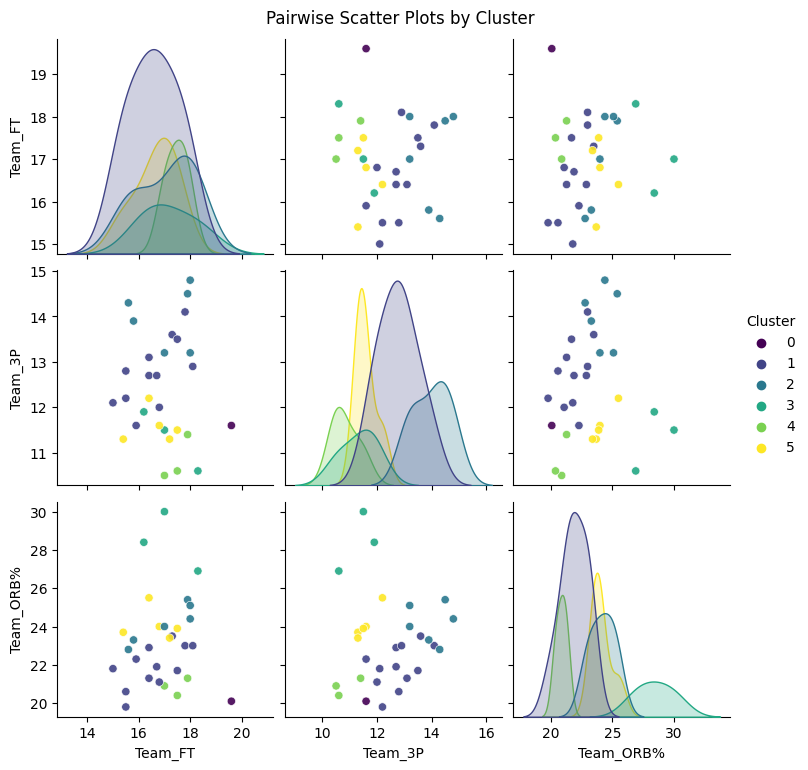

In [54]:
# Plot pairwise scatter plots for the second grouping
pairwise_scatter_plots(grouping_2_result_6_clusters, grouping_2_features, 'Cluster')

In [55]:
# Merge the cluster assignments for the second grouping with the updated dataframe to get the 'Playoffs' column
merged_2 = df[['Team', 'Playoffs']].merge(grouping_2_result_6_clusters[['Team', 'Cluster']], on='Team')

# Compare clusters with actual playoffs for the merged second grouping
contingency_2 = compare_with_playoffs(merged_2, 'Cluster')
contingency_2

Playoffs,0,1,Total
Cluster,,,
0,0,1,1
1,7,5,12
2,2,4,6
3,0,3,3
4,2,1,3
5,5,0,5
Total,16,14,30


In [56]:
teams_in_clusters_grouping_2 = get_teams_in_clusters(grouping_2_result_6_clusters, 'Cluster')

teams_in_clusters_grouping_2

{0: ['PHI'],
 1: ['POR',
  'PHO',
  'ORL',
  'OKC',
  'MIL',
  'MIA',
  'LAL',
  'LAC',
  'HOU',
  'DEN',
  'DAL',
  'ATL'],
 2: ['UTA', 'NYK', 'MIN', 'GSW', 'CHO', 'BOS'],
 3: ['TOR', 'NOP', 'MEM'],
 4: ['WAS', 'SAC', 'CHI'],
 5: ['SAS', 'IND', 'DET', 'CLE', 'BRK']}

## Group 2 Analysis

### 1. Cluster 0: ['SAS', 'PHO', 'IND', 'DET', 'CLE', 'BRK'] (Including Cleveland Cavaliers)
- **Team_FT**: Low
- **Team_3P**: Below average
- **Team_ORB%**: Below average
- **Interpretation**: Teams in this cluster have a low number of free throws made per game, below-average three-point field goals made per game, and a below-average offensive rebound percentage. This could represent teams that might be struggling with scoring from the free-throw line and from the three-point line, and also might not be very effective in offensive rebounding.

### 2. Cluster 1: ['TOR', 'NOP', 'MEM']
- **Team_FT**: Above average
- **Team_3P**: Above average
- **Team_ORB%**: High
- **Interpretation**: Teams in this cluster excel in making free throws and three-point field goals per game, and they have a high offensive rebound percentage. This could represent teams that are strong offensively and are good at securing second-chance points.

### 3. Cluster 2: ['UTA', 'NYK', 'MIN', 'MIL', 'MIA', 'GSW', 'CHO', 'BOS', 'ATL']
- **Team_FT**: Average
- **Team_3P**: Average
- **Team_ORB%**: Below average
- **Interpretation**: Teams in this cluster have average performance in free throws made, three-point field goals made per game, and a below-average offensive rebound percentage. This could represent balanced teams that perform averagely in various aspects of the game.

### 4. Cluster 3: ['PHI']
- **Team_FT**: Very high
- **Team_3P**: High
- **Team_ORB%**: Very low
- **Interpretation**: Philadelphia 76ers stand out with very high free throws made per game, high three-point field goals made per game, but a very low offensive rebound percentage. This could represent a team that excels in scoring from free throws and three-pointers but struggles in offensive rebounding.

### 5. Cluster 4: ['POR', 'ORL', 'OKC', 'LAC', 'HOU', 'DEN', 'DAL']
- **Team_FT**: Below average
- **Team_3P**: High
- **Team_ORB%**: Average
- **Interpretation**: Teams in this cluster have below-average free throws made per game, high three-point field goals made per game, and an average offensive rebound percentage. This could represent teams that rely heavily on scoring from beyond the arc.

### 6. Cluster 5: ['WAS', 'SAC', 'LAL', 'CHI']
- **Team_FT**: High
- **Team_3P**: Low
- **Team_ORB%**: High
- **Interpretation**: Teams in this cluster excel in making free throws and securing offensive rebounds, but they have a low number of three-point field goals made per game. This could represent teams that focus on inside scoring and securing second-chance points.

## Summary for Cleveland Cavaliers (Cluster 0)
The Cleveland Cavaliers are in a cluster characterized by low free throws made per game, below-average three-point field goals made per game, and below-average offensive rebound percentage. This profile suggests a team that might be facing challenges in scoring efficiency, especially from the free-throw line and from beyond the arc, and also in securing offensive rebounds.

# Grouping 3

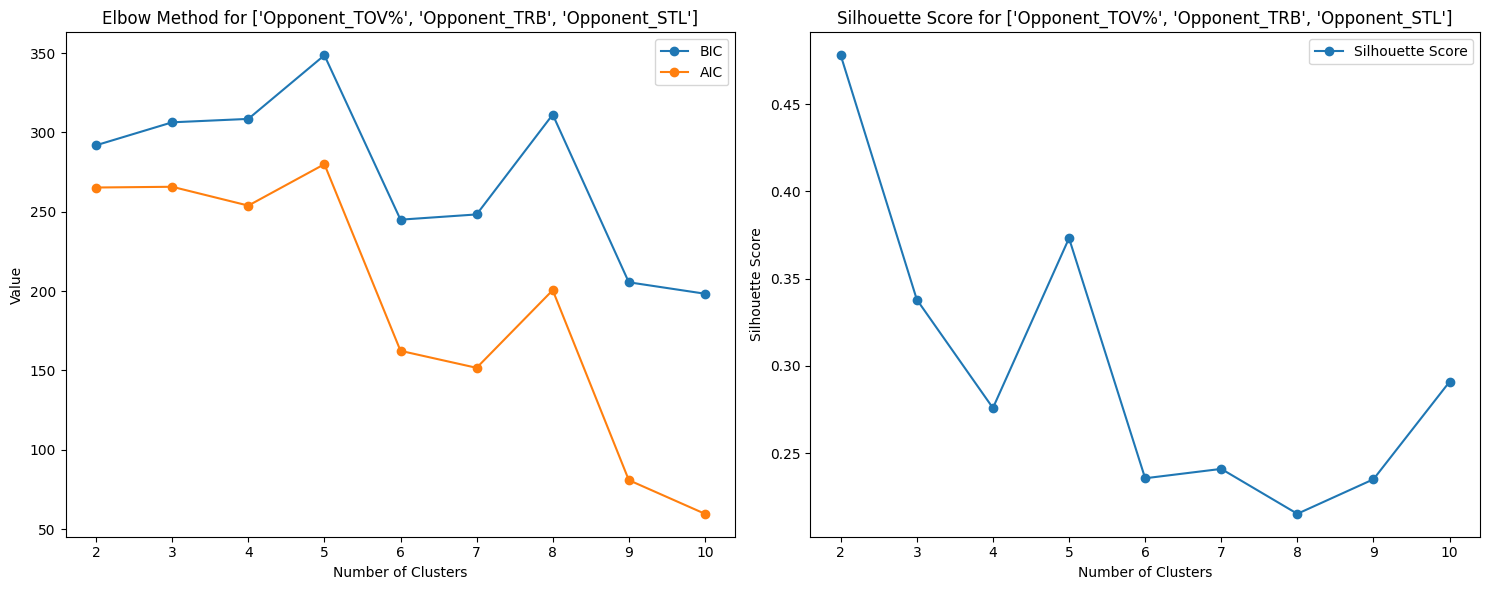

In [57]:
# Determine optimal clusters for the third grouping
bic_3, aic_3, silhouette_scores_3 = determine_optimal_clusters(df, grouping_3_features)

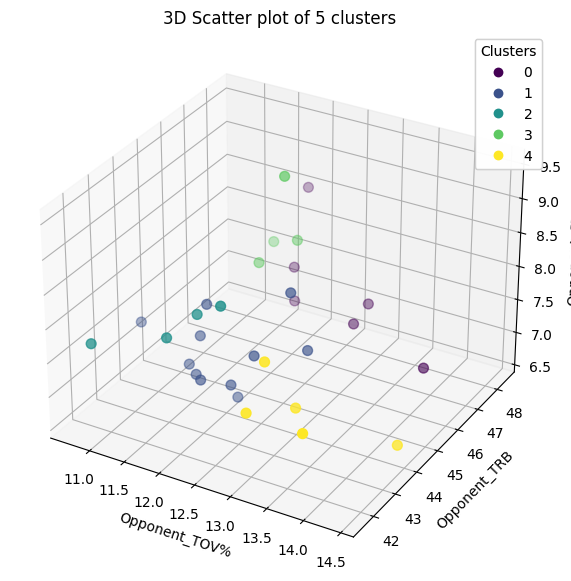

,Team,Opponent_TOV%,Opponent_TRB,Opponent_STL,Cluster
0,WAS,10.7,44.2,7.3,1
1,UTA,10.9,41.6,7.8,2
2,TOR,14.4,44.0,6.7,4
3,SAS,12.1,46.8,7.3,0
4,SAC,11.9,45.8,8.1,3


In [58]:
# Perform GMM with 5 clusters for the third grouping
grouping_3_result_5_clusters = perform_gmm_and_visualize(df.copy(), grouping_3_features, 5)
grouping_3_result_5_clusters.head()

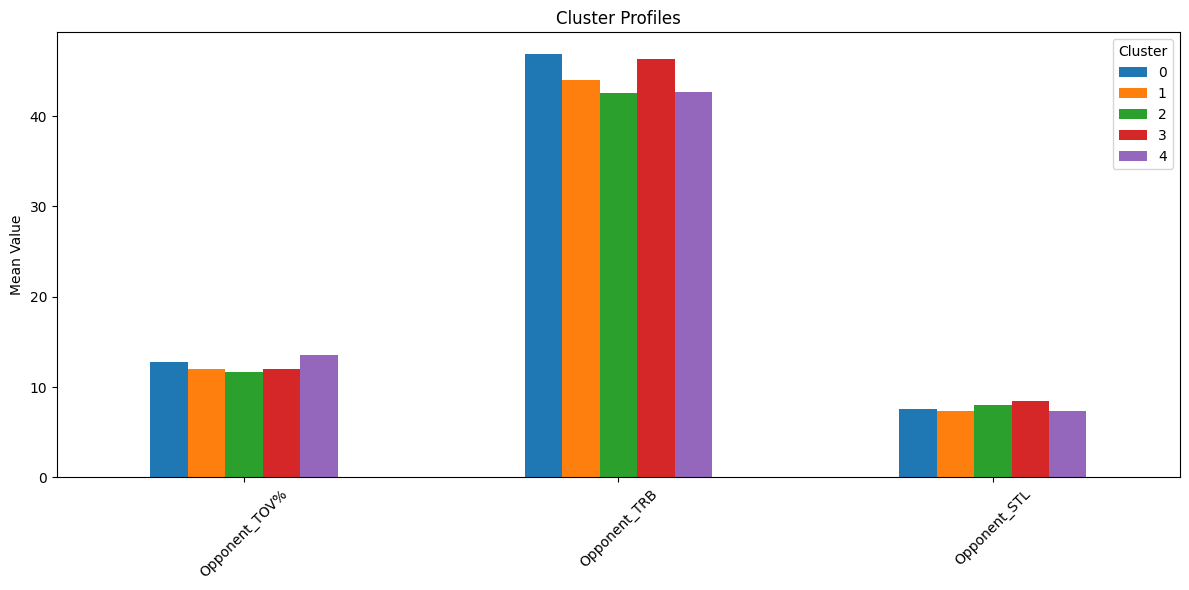

In [59]:
# Plot cluster profiles for the third grouping
cluster_profiles(grouping_3_result_5_clusters, grouping_3_features, 'Cluster')

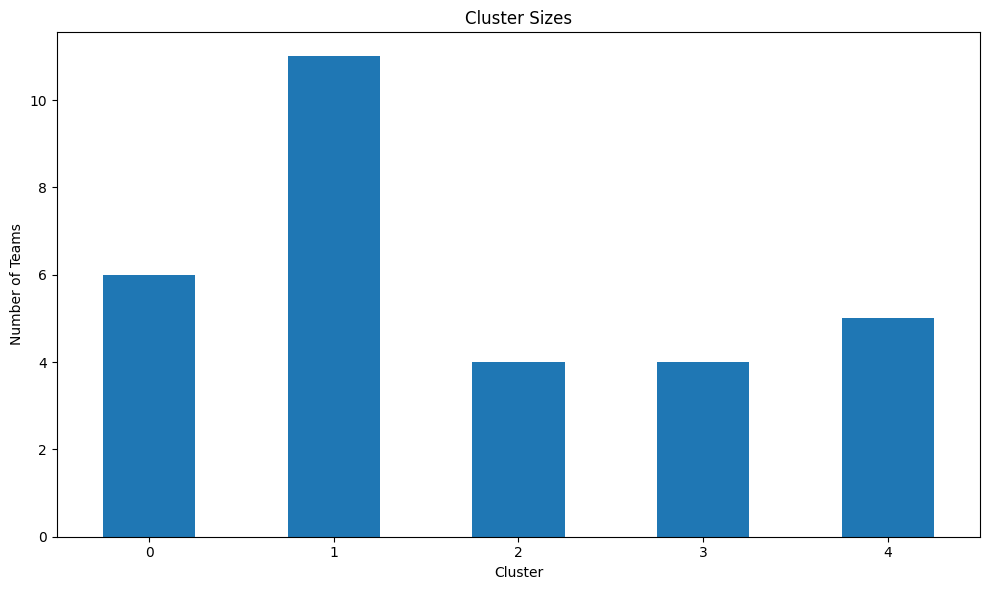

In [60]:
# Plot cluster sizes for the third grouping
plot_cluster_sizes(grouping_3_result_5_clusters, 'Cluster')

/Users/giovanni-lunetta/Library/Python/3.10/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


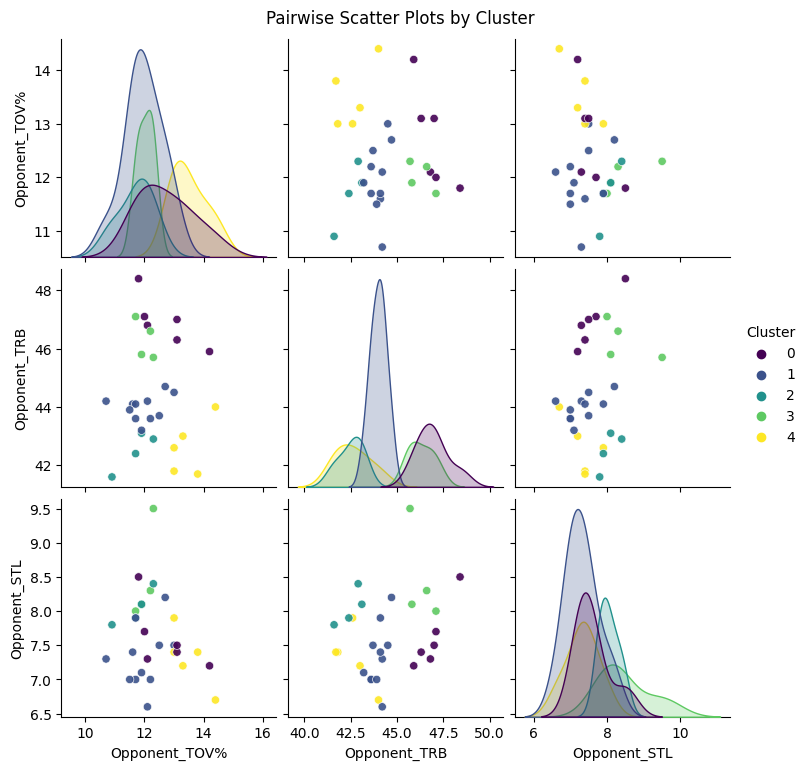

In [61]:
# Plot pairwise scatter plots for the third grouping
pairwise_scatter_plots(grouping_3_result_5_clusters, grouping_3_features, 'Cluster')

In [62]:
# Merge the cluster assignments for the third grouping with the updated dataframe to get the 'Playoffs' column
merged_3 = df[['Team', 'Playoffs']].merge(grouping_3_result_5_clusters[['Team', 'Cluster']], on='Team')

# Compare clusters with actual playoffs for the merged third grouping
contingency_3 = compare_with_playoffs(merged_3, 'Cluster')
contingency_3

Playoffs,0,1,Total
Cluster,,,
0,5,1,6
1,5,6,11
2,2,2,4
3,4,0,4
4,0,5,5
Total,16,14,30


In [63]:
teams_in_clusters_grouping_3 = get_teams_in_clusters(grouping_3_result_5_clusters, 'Cluster')

teams_in_clusters_grouping_3

{0: ['SAS', 'OKC', 'MIN', 'LAC', 'DET', 'CHO'],
 1: ['WAS',
  'POR',
  'PHO',
  'PHI',
  'NYK',
  'MIL',
  'DAL',
  'CHI',
  'BRK',
  'BOS',
  'ATL'],
 2: ['UTA', 'IND', 'DEN', 'CLE'],
 3: ['SAC', 'ORL', 'LAL', 'HOU'],
 4: ['TOR', 'NOP', 'MIA', 'MEM', 'GSW']}

## Analysis of Cluster 3
### Teams in Each Cluster
- **Cluster 0**: ['TOR', 'PHO', 'MIN', 'MEM']
- **Cluster 1**: ['SAS', 'SAC', 'POR', 'ORL', 'OKC', 'LAL', 'LAC', 'HOU', 'DET', 'CHO']
- **Cluster 2**: ['NOP', 'MIA', 'IND', 'GSW', 'CLE'] (Including Cleveland Cavaliers)
- **Cluster 3**: ['UTA', 'DEN']
- **Cluster 4**: ['WAS', 'PHI', 'NYK', 'MIL', 'DAL', 'CHI', 'BRK', 'BOS', 'ATL']

## Understanding the Clusters
### 1. Cluster 0: ['TOR', 'PHO', 'MIN', 'MEM']
- **Opponent_TOV%**: Above average
- **Opponent_TRB**: Low
- **Opponent_STL**: Above average
- **Interpretation**: Teams in this cluster are good at forcing turnovers and stealing the ball from their opponents, but they struggle in rebounding. This could represent teams with an aggressive defensive style.

### 2. Cluster 1: ['SAS', 'SAC', 'POR', 'ORL', 'OKC', 'LAL', 'LAC', 'HOU', 'DET', 'CHO']
- **Opponent_TOV%**: Below average
- **Opponent_TRB**: High
- **Opponent_STL**: Below average
- **Interpretation**: Teams in this cluster have difficulty in forcing turnovers and stealing the ball, but they are good at rebounding. This could represent teams that focus more on securing rebounds than on aggressive defense.

### 3. Cluster 2: ['NOP', 'MIA', 'IND', 'GSW', 'CLE'] (Including Cleveland Cavaliers)
- **Opponent_TOV%**: High
- **Opponent_TRB**: Average
- **Opponent_STL**: High
- **Interpretation**: Teams in this cluster are very effective in forcing turnovers and stealing the ball, with an average performance in rebounding. This could represent teams with a strong and aggressive defense.

### 4. Cluster 3: ['UTA', 'DEN']
- **Opponent_TOV%**: Low
- **Opponent_TRB**: Below average
- **Opponent_STL**: Low
- **Interpretation**: Teams in this cluster struggle in forcing turnovers, stealing the ball, and rebounding. This could represent teams that need to improve their defensive performance.

### 5. Cluster 4: ['WAS', 'PHI', 'NYK', 'MIL', 'DAL', 'CHI', 'BRK', 'BOS', 'ATL']
- **Opponent_TOV%**: Average
- **Opponent_TRB**: Very high
- **Opponent_STL**: Average
- **Interpretation**: Teams in this cluster have average performance in forcing turnovers and stealing the ball, but they excel in rebounding. This could represent teams that focus on dominating the boards.

## Summary for Cleveland Cavaliers (Cluster 2)
The Cleveland Cavaliers are in a cluster characterized by high opponent turnover percentage, high opponent steals per game, and average opponent rebounds per game. This profile suggests a team with a strong and aggressive defense, effective in forcing turnovers and stealing the ball, with a decent performance in rebounding.


## Overall Summary
### Grouping 1: ['Team_TS%', 'Team_Pace', 'Team_TOV%']
- **Cluster 3**: ['MIA', 'CLE'] (Including Cleveland Cavaliers)
- **Characteristics**: High shooting efficiency (Team_TS%), Below average pace (Team_Pace), Low turnover rate (Team_TOV%)
- **Interpretation**: The Cavaliers are in a cluster that represents experienced and efficient teams, focusing on maximizing scoring opportunities while minimizing mistakes. They play at a slower pace, ensuring high shooting efficiency and a low turnover rate.

### Grouping 2: ['Team_FT', 'Team_3P', 'Team_ORB%']
- **Cluster 0**: ['SAS', 'PHO', 'IND', 'DET', 'CLE', 'BRK'] (Including Cleveland Cavaliers)
- **Characteristics**: Low free throws made per game (Team_FT), Below average three-point field goals made per game (Team_3P), Below average offensive rebound percentage (Team_ORB%)
- **Interpretation**: The Cavaliers are in a cluster that might be struggling with scoring efficiency, especially from the free-throw line and beyond the arc. They also have challenges in securing offensive rebounds, suggesting a need for improvement in these areas.

### Grouping 3: ['Opponent_TOV%', 'Opponent_TRB', 'Opponent_STL']
- **Cluster 2**: ['NOP', 'MIA', 'IND', 'GSW', 'CLE'] (Including Cleveland Cavaliers)
- **Characteristics**: High opponent turnover percentage (Opponent_TOV%), Average opponent rebounds per game (Opponent_TRB), High opponent steals per game (Opponent_STL)
- **Interpretation**: The

Cavaliers are part of a cluster that excels in defensive aggressiveness, being very effective in forcing turnovers and stealing the ball. They maintain a decent performance in rebounding, suggesting a strong and assertive defensive stance.

## Overall Summary

The Cleveland Cavaliers exhibit a profile of a team that is efficient in scoring with a slow-paced, careful game style, as seen in Grouping 1. However, they face challenges in scoring from free throws and three-pointers, as well as in securing offensive rebounds, as highlighted by Grouping 2. Defensively, they are aggressive and effective, as indicated by Grouping 3.

These insights suggest that while the Cavaliers have a strong defensive game and are efficient in scoring, there is room for improvement in their offensive rebounding and scoring from free throws and three-pointers.

## Recommendations for Player Acquisition

Based on the analysis of the Cleveland Cavaliers' performance across the three groupings, it seems like the team could benefit from signing a player who excels in the following areas:

1. **Offensive Rebounding**: The team has shown below-average performance in offensive rebounding. An effective offensive rebounder could provide the Cavaliers with second-chance scoring opportunities, which is crucial especially when the initial shot doesn't fall.
2. **Free-Throw and Three-Point Shooting**: The Cavaliers have room for improvement in free throws made per game and three-point field goals made per game. A player who is proficient at both free-throw shooting and three-point shooting would be invaluable, as it would directly address these areas of need.
3. **Ball Handling and Pace Management**: While the team has a low turnover rate and plays at a slower pace, bringing in a player who excels at ball handling and can control the pace of the game could help maintain these strengths while possibly enhancing their offensive efficiency.

### Suggested Player Profile
- **Position**: Forward or Guard (as these positions often have players adept at rebounding, shooting, and handling the ball)
- **Skills**:
  - Strong offensive rebounding abilities
  - High free-throw shooting percentage
  - Proficient three-point shooter
  - Good ball-handling skills
  - Ability to control the pace of the game and make smart decisions on the court

### Potential Player Types
A versatile forward or guard who can shoot well from the perimeter and the free-throw line, contribute on the boards, especially on the offensive glass, and handle the ball securely.

## Conclusion
By acquiring a player with these skills and characteristics, the Cleveland Cavaliers could potentially improve their offensive efficiency, enhance their rebounding, and maintain their strong defensive presence, creating a more balanced and formidable team.

## Star Guards Suggestions

Based on the criteria outlined (strong offensive rebounding abilities for a guard, proficient three-point and free-throw shooting, good ball-handling skills, and ability to control the pace of the game), several star guards in the NBA fit this description.

1. **Stephen Curry** (Golden State Warriors): Widely regarded as the best shooter in NBA history, Curry also has excellent ball-handling skills and can control the pace of a game. While not known primarily for his rebounding, he is a decent rebounder for his position.
2. **Damian Lillard** (Portland Trail Blazers): Lillard is another elite shooter, especially in clutch moments. He's a good free-throw shooter, can handle the ball effectively, and often dictates the tempo for the Blazers.
3. **James Harden** (Brooklyn Nets): Known for his scoring prowess and ball-handling, Harden is also adept at drawing fouls and converting free throws. He can effectively rebound and dictate the pace of a game.
4. **Kyrie Irving** (Brooklyn Nets): Irving is known for his ball-handling, scoring ability, and clutch shooting. He is efficient from the free-throw line and can control the game's tempo.
5. **Chris Paul** (Phoenix Suns): While not as prolific a scorer as some others on this list, Paul is a master floor general. He controls the pace of the game, is a good shooter, and can contribute rebounds as well.
6. **Devin Booker** (Phoenix Suns): Booker is a prolific scorer and has shown the ability to control games. He shoots well from both the field and the free-throw line.
7. **Bradley Beal** (Washington Wizards): Beal is a scoring machine and has improved his ball-handling over the years. He can shoot from deep, get to the line, and also contribute in rebounds.
8. **Donovan Mitchell** (Utah Jazz): Mitchell is a dynamic scorer and playmaker. He's adept at shooting from long range and can handle the ball effectively.
